### Anadarko TX&NM Cuttings-Fluids Overlap

-------
**Job Code:** R&D

**Author:** Hasan Shojaei

**Analysis Type:** Cuttings-Fluids Overlap

**Project Goals:**
* The main goals of this R&D project is to see how DNA signal changes as we move away from the cuttings baseline well

**Date Last Modified:** 2019-04-04

**Data Through Group:** 107

**Main Findings:**
- The number of fluid features that are also found in cutting baseline (from Silvertip 8H well) appear to be decreasing with distance from the cutting source
- The percentage of fluid features shared by cutting baseline remains relatively constant (~80%) up until 30 miles that we have data for. 
- We only used Silvertip 8H cuttings because the majority of cuttings from other Silvertip wells didn't pass QC and NEC Plate names were not available for Thresher well

**Notes:**

-This notebook depends on files that were generated in APC_TXcuttings_qc.ipynb and APC_TXNMfluids_qc.ipynb, which should be run before this one.


-------

#### General Tools:

In [1]:
# Declaring path variables to make Basemap work in jupyter hub. Make sure that the conda environment path matches yours
import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2018.8/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2018.8/share/proj'

In [2]:
# General Tool Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap
import biota
import biota.plot as bpl
import seaborn as sns
import collections
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math

from biota.database import (get_samples,
                            get_sample_data,
                            get_pg_connection,
                            get_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
from IPython.core.display import display, HTML
from pickle import dump, load

import lasio

# SQL Query imports
from sqlalchemy import create_engine, engine, inspect

from functools import partial

from ipyparallel import Client
from sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from skbio.stats.ordination import pcoa

from biota.util import assign_formations

%matplotlib inline

#### Data Query:

In [3]:
#Establish link with database
con = get_pg_connection()

/home/jovyan/my-conda-envs/qiime2-2018.8/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [47]:
#fluids = pd.read_csv('../shared/APC_TXNM_fluids_04012019.txt', sep='\t', index_col=0)
fluids = pd.read_csv('../shared/APC_TXNM_fluids_passing_qc_04042019.txt', sep='\t', index_col=0)

In [48]:
#cuttings = pd.read_csv('../shared/APC_TX_cuttings_04012019.txt', sep='\t', index_col=0)
cuttings = pd.read_csv('../shared/APC_TX_cuttings_passing_qc_04012019.txt', sep='\t', index_col=0)

In [49]:
cuttings = cuttings.loc[cuttings.wellname=='silvertip.76.7.unit.a.8h']

In [50]:
samples = pd.concat([cuttings, fluids])

In [51]:
data, features = get_data({'_id': {'$in': samples.index.tolist()}})

The filtering function dropped 0 samples and 40227 features


#### Map!

In [52]:
samples['color'] = samples.fieldsampletype

In [53]:
samples['marker'] = 'o'

In [54]:
samples.color.replace({'wellcutting':'red',
                        'produced.fluid':'blue'}, inplace=True)

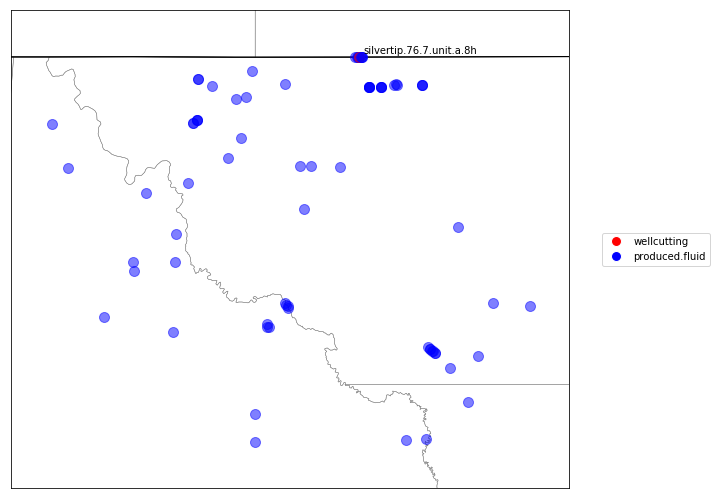

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

Wells = samples.groupby('wellname').first()
Wells = Wells.loc[Wells.longitude < 0]
lat = list(Wells.latitude.astype(float))
long = list(Wells.longitude.astype(float))

buffer = 0.05

map = Basemap(llcrnrlon=min(Wells.longitude)-buffer, urcrnrlon=max(Wells.longitude)+buffer,
                  lon_0=0.5*(min(Wells.longitude)+max(Wells.longitude)),
                  llcrnrlat=min(Wells.latitude)-buffer, urcrnrlat=max(Wells.latitude)+buffer,
                  lat_0=0.5*(min(Wells.latitude)+max(Wells.latitude)),
                  projection='tmerc')
# add county boundaries
map.readshapefile('/home/jovyan/my-conda-envs/qiime2-2018.8/share/basemap/cb_2017_us_county_500k',
                  'counties',drawbounds=True,
                  linewidth=0.45,color='gray')
# add state boundaries
map.readshapefile('/home/jovyan/my-conda-envs/qiime2-2018.8/share/basemap/st99_d00','states',
                  drawbounds=True,linewidth=1,color='black')

for i, r in Wells.iterrows():
    x, y = map(r.longitude, r.latitude)
    map.plot(x, y, marker=r.marker, c=r.color, ms=10, alpha=0.5)
    if i in ['silvertip.76.7.unit.a.8h']:
        ax.annotate(i, (x+500, y+500))
    
# map.drawmapscale(min(long)+0.15, min(lat), 0.5*(min(long)+max(long)), 0.5*(min(lat)+max(lat)), 
#                  length=10, barstyle='simple', units='mi')

F0 = Line2D([],[], marker='o', color='w', markerfacecolor='red', label='wellcutting', markersize=10)
F1 = Line2D([],[], marker='o', color='w', markerfacecolor='blue', label='produced.fluid', markersize=10)
ax.legend(handles=[F0,F1],loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.savefig('../images/APC_cuttings_vs_fluids_map_QCed.png', dpi=300, bbox_inches='tight')

#### Cuttings-Fluids Overlap:

In [95]:
results = pd.DataFrame(index=fluids.wellname.unique(),
                       columns=('Total fluid features', 'Total fluid features found in cuttings', 'Percentage fluid features found in cuttings',
                                'well-unique fluid features',  'well-unique fluid features found in cuttings'))

In [57]:
# rarefying data for fluids and well cuttings
data_r5k = rarefy(data, 5000)

In [58]:
# define fluid features 
data_f = data_r5k.reindex(index=fluids.index).copy()
f_fts = set(data_f.loc[:, data_f.sum(axis=0) > 0].columns)

In [59]:
# define cutting features 
data_wc = data_r5k.reindex(index=cuttings.index).copy()
wc_fts = set(data_wc.loc[:, data_wc.sum(axis=0) > 0].columns)

In [96]:
for well, group in fluids.groupby('wellname'):
    data_well = data_f.reindex(index=group.index).copy()
    f_well_fts = set(data_well.loc[:, data_well.sum(axis=0) > 0].columns)
    
    Indx = fluids.loc[fluids.wellname != well].index
    data_otherwell = data_f.reindex(index=Indx).copy()
    f_otherwell_fts = set(data_otherwell.loc[:, data_otherwell.sum(axis=0) > 0].columns)
    
    f_well_uniquefts = f_well_fts - f_otherwell_fts
    
    shared_fts = wc_fts & f_well_fts
    unique_shared_fts = wc_fts & f_well_uniquefts
    
    results.loc[well] = [len(f_well_fts), len(shared_fts), 100*len(shared_fts)/len(f_well_fts) ,
                         len(f_well_uniquefts), len(unique_shared_fts)]

In [97]:
results.index.name = 'wellname'

In [83]:
results.to_csv('../shared/fluids_cuttings_feature_overlap_QCedSamples.csv', sep=',')

In [98]:
WellLocations = samples.groupby(['wellname']).first().copy()[['latitude','longitude']]

In [64]:
# define a function to calculate distance between two wells in miles 
# courtesy of Wayne Dyck: https://gist.github.com/rochacbruno/2883505
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371*0.621371 # miles

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [99]:
WellLocations['Distance_to_cuttings'] = 0

In [100]:
cuttings.wellname.unique()

array(['silvertip.76.7.unit.a.8h'], dtype=object)

In [101]:
# we want to calculate each well's distance to margaret sue kelley 3h
origin = WellLocations.loc['silvertip.76.7.unit.a.8h', ['latitude','longitude']]

In [102]:
for i, r in WellLocations.iterrows():
    destination = r['latitude'], r['longitude']
    WellLocations.loc[i,'Distance_to_cuttings'] = distance(origin, destination)

In [103]:
results['Distance_to_cuttings'] = WellLocations.Distance_to_cuttings

In [104]:
results2  = results.loc[results.Distance_to_cuttings < 100]

In [105]:
results2.sort_values(by='Distance_to_cuttings', inplace=True)

/home/jovyan/my-conda-envs/qiime2-2018.8/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


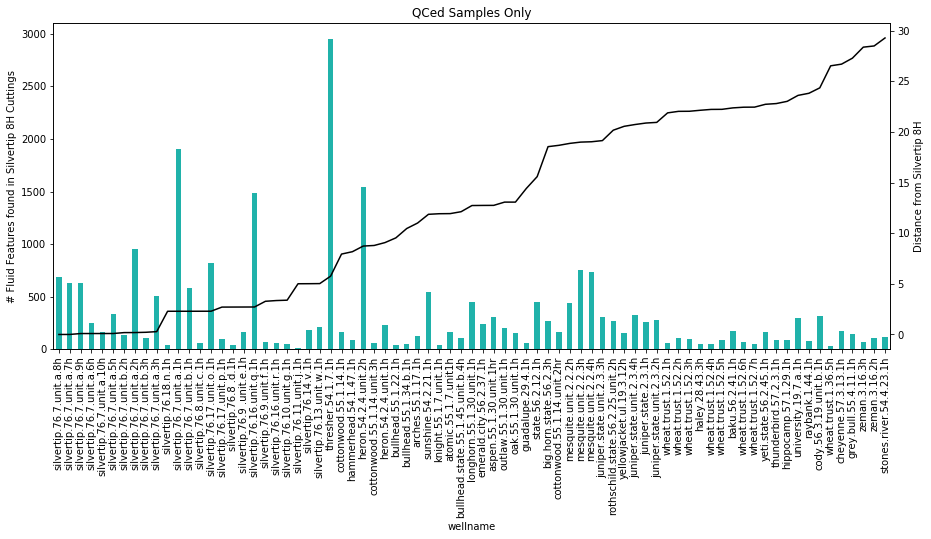

In [107]:
fig, ax = plt.subplots(1, figsize=(15,6))

results2[['Total fluid features found in cuttings']].plot(kind='bar', stacked=False, ax=ax,
             color=['lightseagreen'], legend=False)

ax.set(ylabel='# Fluid Features found in Silvertip 8H Cuttings', 
       title='QCed Samples Only')

ax2 = ax.twinx()
results2.Distance_to_cuttings.plot(kind='line', ax=ax2, style='k-', legend=False)
ax2.set_ylabel('Distance from Silvertip 8H')

fig.savefig('../images/APC_cuttings_vs_fluids_shared_features_QCedsamples.png', dpi=300, bbox_inches='tight')

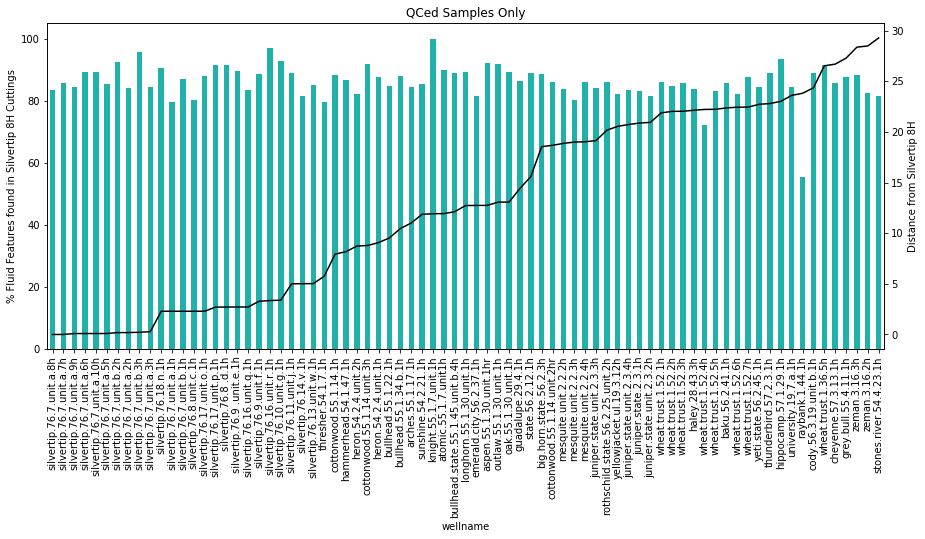

In [92]:
fig, ax = plt.subplots(1, figsize=(15,6))

results2[['Percentage fluid features found in cuttings']].plot(kind='bar', stacked=False, ax=ax,
             color=['lightseagreen'], legend=False)

ax.set(ylabel='% Fluid Features found in Silvertip 8H Cuttings', 
       title='QCed Samples Only')

ax2 = ax.twinx()
results2.Distance_to_cuttings.plot(kind='line', ax=ax2, style='k-', legend=False)
ax2.set_ylabel('Distance from Silvertip 8H')

fig.savefig('../images/APC_percent_fluid_features_incuttings_QCedsamples.png', dpi=300, bbox_inches='tight')

##### Thoughts:

- The number of fluid features that are also found in cutting baseline (from Silvertip 8H well) appear to be decreasing with distance from the cutting source
- The percentage of fluid features shared by cutting baseline remains relatively constant (~80%) up until 30 miles that we have data for.